# Counting all the possible non-monotone sequences of a finite discrete set
by [Valerio Morelli](https://github.com/MrPio).

## The problem definition
Let $\mathcal{A}$ be an alphabet of $n$ ordinal elements, i.e. within which an ordering relation is defined. **We ask how many sequences of elements of $\mathcal{A}$, of length $l$, can be constructed so that they are non-monotone**.

For instance, if $\mathcal{A}=\{1,2,3,4,5\}$, with $a_1\prec a_2 \iff a_1 < a_2$, and $l=4$, some non-monotone sequences are: $[1,3,5,2]$, $[4,1,4,4]$ and $[1,5,1,5]$, but not $[1,1,1,1]$ nor $[5,3,3,2]$.

## Total enumeration
A first approach to tackle the problem is the brute force method.

Let $\mathcal{P}([a_1,a_2,...,a_l])=\exists{i} (a_i\le a_{i+1}) \wedge \exists{j} (a_j\ge a_{j+1})$:
1. List all the solutions $\mathbf{a}=[a_1,a_2,...,a_l]$, with $a_i\in \mathcal{A}, \forall i: 1\leq i\leq l$,
2. Evaluate which of them satisfy the property $\mathcal{P}$, namely, find $\xi=\{\mathbf{a}|\mathcal{P}(\mathbf{a})\}$,
3. Determine $|\xi|$.

This algorithm clearly has an exponentially growing search space. Furthermore, since it evaluates every solution, its complexity is exponential.

### Implementation
The total enumeration algorithm can be implemented without a great deal of effort in the following way. The time complexity of the algorithm below is $\mathcal{O}(n^l\times 2(n-1))=\mathcal{O}(n^{l+1})$

In the following, we will consider $\mathcal{A}$ to be the alphabet of 26 Latin letters, thus $n=26$. So the problem is to find the number of all possible strings of length $l$ where the letters are not in non-decreasing or non-increasing order.

In [5]:
from itertools import product

n = 26
l = 5


def is_monotone(seq: list[int], non_decreasing: bool) -> bool:
    return all(x <= y if non_decreasing else x >= y for x, y in zip(seq[:-1], seq[1:]))


non_monotone_sequences = sum(
    1 for l in product(range(n), repeat=l)
    if not is_monotone(l, non_decreasing=True) and not is_monotone(l, non_decreasing=False)
)

non_monotone_sequences

11596390

Here, the `product` function from the `itertools` module is used to generate all the possible sequences of lenght $l$.

For $n=26$ and $l=5$, the code found the solution $11,596,390$ in $16.9$ seconds on an *Intel i-7 10750H* laptop processor.

## Toward a non-recursive formula
Since the total enumeration method is intractable, we'll look for a better approach to solving the counting problem.

### Complementary problem of non-decreasing monotone sequences
The goal is to find the function $B(n,l)$, defined as **the number of all possible *non-monotone* sequences of length $l$, of an alphabet of length $n$**.
However, for simplicity reasons, we choose to consider the complementary problem, namely finding the function $A(n,l)$ defined as **the number of all the possible *non-decreasing monotone* sequences**.

The two problems are equivalent since $$B(n,l)=n^l-2\times A(n,l)+n,$$ 
where $n^l$ is the number of possible sequences, i.e. $|\{[a_1,...,a_l]|a_i\in \mathcal{A}, \forall i: 1\leq i\leq l\}| =|\mathcal{A}|^l=n^l$ and $2\times A(n,l)-n$ is the number of all possible non-decreasing monotone sequences plus the number of all possible non-increasing monotone sequences minus n, i.e. the number of all possible constant sequences, which would otherwise be counted twice.

In Python terms, the function $B$ is defined as follows:

In [2]:
def B(n, l):
    return n**l - 2*A(n, l) + n

### The recursive approach
At some expense, we can define the $A$ function as $$A(n,l)=
    \begin{cases}
      \sum_{i=0}^{n-1}{A(n-i,l-1)} &\text{if } l>1\\
      n &\text{if } l=1
    \end{cases}.$$
We observe that, for $l=2$, $A$ becomes the Gauss function, i.e. $A(n,2)=G(n)=\dfrac{n(n+1)}{2}$.

In Python terms, the function $A$ is defined as follows:

In [31]:
def A(n: int, l: int) -> int:
    return n if l == 1 else sum(A(n-i, l-1) for i in range(n))


B(n, l)

11596390

For $n=26$ and $l=5$, the code found the same solution as before, i.e. $11,596,390$, with an average time of $5.2$ milliseconds on the same hardware. This is 3,250 times faster than the brute force algorithm.

But this is still not enough. Even though the algorithm is much faster than before, it is derived from an open formula and has the exponential time complexity of $\mathcal{O}(n^{l-1})$. This is empirically proven below.

In [ ]:
from time import time_ns

avg_times = []
for l in range(2, 18):
    times = []
    for _ in range(2):
        s = time_ns()
        B(10, l)
        times.append(time_ns()-s)
    avg_times.append(sum(times)/len(times)/1e6)

<Axes: xlabel='l', ylabel='t(ms)'>

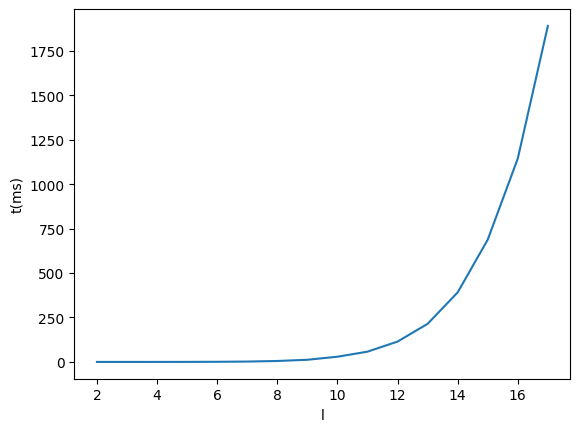

In [63]:
import seaborn
import pandas as pd

seaborn.lineplot(pd.DataFrame(
    {'t(ms)': avg_times, 'l': range(2, 18)}), x='l', y='t(ms)')

## A different point of view
The way we've been going won't lead us anywhere. We need a change of perspective to exploit the mathematical properties of the problem.

Let's consider a simple case of an alphabet of size $n=4$.

<p align="center">
    <img src="img/example_1_2.png" width="30%">
</p>

The reason is as follows: 
1. fix the first 3 sequence elements with the lowest element of the alphabet. How many sequences can be constructed in this way? $4$, since the last element, the 4th, can be any element of the alphabet and the sequence is always non-decreasing monotone,
2. gradually move the 3rd sequence element up. The 4th can assume $3$, then $2$, and then $1$ different values,
3. repeat the reasoning for the 2nd and the 1st sequence elements.

### The building block

It is clear that we need at least 3 elements to create a non-monotone sequence, so let's consider $l=3$. The possible configurations can be summarised in the following table, where the cell contains the possible values for the sequence element $a_1$, given the values of the other two elements $a_2$ and $a_3$. Summing up all the cells gives us $A(4,3)$.

||$a_2=1$|$a_2=2$|$a_2=3$|$a_2=4$|
|---|:---:|:---:|:---:|:---:|
|$a_3=1$| 4 | 3 | 2 | 1 |
|$a_3=2$| -  | 3 | 2 | 1 |
|$a_3=3$|  - | -  | 2 | 1 |
|$a_3=4$|   -|-   | -  | 1 |

Following the reasoning described above, we can expand the table for $l=4$ as shown below.

<table><thead><tr><th colspan="2"></th><th>a2=1</th><th>a2=2</th><th>a2=3</th><th>a2=4</th></tr></thead><tbody><tr><td rowspan="4">a4=1</td><td>a3=1</td><td>4</td><td>3</td><td>2</td><td>1</td></tr><tr><td>a3=2</td><td>-</td><td>3</td><td>2</td><td>1</td></tr><tr><td>a3=3</td><td>-</td><td>-</td><td>2</td><td>1</td></tr><tr><td>a3=4</td><td>-</td><td>-</td><td>-</td><td>1</td></tr><tr><td rowspan="3">a4=2</td><td>a3=2</td><td>-</td><td>3</td><td>2</td><td>1</td></tr><tr><td>a3=3</td><td>-</td><td>-</td><td>2</td><td>1</td></tr><tr><td>a3=4</td><td>-</td><td>-</td><td>-</td><td>1</td></tr><tr><td rowspan="2">a4=3</td><td>a3=3</td><td>-</td><td>-</td><td>2</td><td>1</td></tr><tr><td>a3=4</td><td>-</td><td>-</td><td>-</td><td>1</td></tr><tr><td>a4=4</td><td>a3=4</td><td>-</td><td>-</td><td>-</td><td>1</td></tr></tbody></table>

It is clear that whatever the size of $l$, the rows added to the table are always chosen between those in the table for $l=3$. So we can reduce the whole counting function to a **linear combination of the $n$ rows** $[n,n-1,...,1],[n-1,n-2,...,1],...,[1]$, where their sums are $A(n,2), A(n-1,2),...,A(1,2) = \frac{n(n+1)}{2}, \frac{(n-1)n}{2}, ..., 1$.

Therefore $A(n,l)=\lambda_n^l A(n,2) + \lambda_{n-1}^l A(n-1,2) + ...+\lambda_1^l A(1,2)$

### Pascal's triangle

We can convice ourselves that $\lambda_i^l=\lambda_i^{l-1}+\lambda_{i-1}^l, \forall{i}$.

We also observe that the first row cannot appear more than once, i.e. $\lambda_n^l=1, \forall{l}$.

Starting from $l=3$, where all the coefficients are obviously equal to 1, we can retrieve the following table.

<table><thead><tr><th colspan="4"></th><th>l=3<br></th><th>l=4</th><th>l=5</th><th>l=6</th><th>l=7</th><th>l=8</th><th>l=9</th><th>l=10</th></tr></thead><tbody><tr><td colspan="4">4 3 2 1</td><td>1</td><td>1</td><td>1</td><td>1</td><td>1</td><td>1</td><td>1</td><td>1</td></tr><tr><td colspan="4">3 2 1</td><td>1</td><td>2</td><td>3</td><td>4</td><td>5</td><td>6</td><td>7</td><td>8</td></tr><tr><td colspan="4">2 1</td><td>1</td><td>3</td><td>6</td><td>10</td><td>15</td><td>21</td><td>28</td><td>36</td></tr><tr><td colspan="4">1</td><td>1</td><td>4</td><td>10</td><td>20</td><td>35</td><td>56</td><td>84</td><td>120</td></tr></tbody></table>

This is the **Pascal's triangle**. From the theory we can derive that $$\lambda_i^l=\binom{i+(l-3)}{i}.$$

### The closed formula
Putting all together, we end up with:
$$A(n,l)=\sum_{i=0}^{n-1}{\dfrac{(n-1)(n-i)}{2}\times \binom{i+(l-3)}{i}}.$$

The formula for the original problem is thus

$$B(n,l)=n^l-2\times \sum_{i=0}^{n-1}{\dfrac{(n-1)(n-i)}{2}\times \binom{i+(l-3)}{i}}+n.$$ 

The Python implementation, shows the same results as the previous approaches, but with a linear time complexity $\mathcal{O}(l)$.

In [10]:
from scipy.special import comb

def G(n): return (n*(n+1))//2


def A(n, l):
    return sum(G(n-i)*comb(l+i-3, i, exact=True) for i in range(n))


B(3, 4),B(3, 5),B(3, 6),B(3, 7),B(3, 8)

(54, 204, 676, 2118, 6474)

In [94]:
from time import time_ns

avg_times = []
for l in range(2, 3000):
    times = []
    for _ in range(100):
        s = time_ns()
        B(10, l)
        times.append(time_ns()-s)
    avg_times.append(sum(times)/len(times)/1e6)

<Axes: xlabel='l', ylabel='t(ms)'>

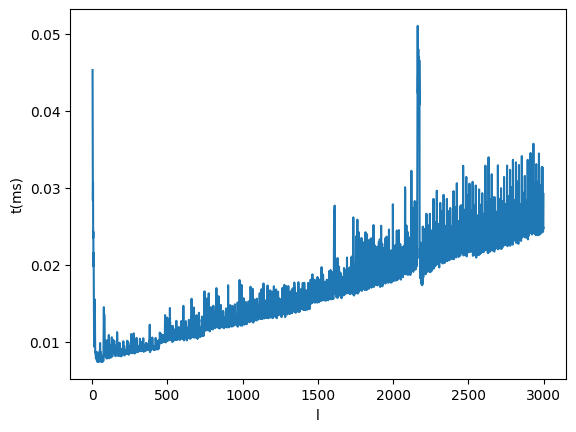

In [95]:
import seaborn
import pandas as pd

seaborn.lineplot(pd.DataFrame(
    {'t(ms)': avg_times, 'l': range(2, 3000)}), x='l', y='t(ms)')